# Project 2
## Aviraj Sinha and Cole Ogden

### 1. Business Understanding (20 points total).  
  `[20 points] Give an overview of the dataset. 
    Describe the purpose of the data set you selected (i.e., why was this data collected in the first place?). 
    What is the prediction task for your dataset and which third parties would be interested in the results? 
    Why is this data important? 
    Once you begin modeling, how well would your prediction algorithm need to perform to be considered useful to the identified third parties? Be specific and use your own words to describe the aspects of the data. `

>stl-10 dataset was used https://cs.stanford.edu/~acoates/stl10/ same set can also be found on kaggle

For our dataset, we selected a group of images to detect the presence of a live animal in the image. We utilized this as a practical application for animal tracking, recognition, and detection.

When evaluating our dataset predictions, we set out to predict their presence for animal tracking services, namely a TV series such as Planet Earth, which depends heaviliy on capturing the moment when an animal appears on screen. Their cameramen wait weeks of inspecting cameras placed around to capture the 2 minutes that will be potent* enough to make it on screen.
![image.png](attachment:image.png)

In [1]:
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from skimage.color import rgb2gray
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from skimage.feature import daisy
from skimage import data
import numpy as np
import glob
import random



### 2. Data Preparation

#### 2.1 Read in your images as numpy arrays. Resize and recolor images as necessary.`

In [2]:
images = []
for filename in glob.glob('./test_images/*.png'):
    img = mpimg.imread(f'{filename}')
    images.append(rgb2gray(img))
print("number of images:", len(images))

number of images: 49


#### 2.2 Linearize the images to create a table of 1-D image features (each row should be one image).

In [3]:
##each row is in its own right now so we must flatten
h, w = images[0].shape
print("dim:",h,w)
#each pixel now has a value
print("pixels:", len(images[0].flatten()))

images_features = []
for image in images:
    images_features.append(image.flatten())
X = images_features

dim: 96 96
pixels: 9216


#### 2.3 Visualize several images.

> using the gallery class example

In [4]:
def plot_gallery(images , h, w, n_row=3, n_col=6):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.7 * n_col, 2.3 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(len(images)):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)

        plt.xticks(())
        plt.yticks(())
        
print("Resized and recolored images")
plot_gallery(images_features[:12], h, w)        

Resized and recolored images


### 3. Data Reduction 

#### 3.1 Perform linear dimensionality reduction of the images using principal components analysis. 


>manipulated from Sebastian Raschka Example

In [5]:
def plot_explained_variance(pca):
    import plotly
    from plotly.graph_objs import Bar, Line
    from plotly.graph_objs import Scatter, Layout
    from plotly.graph_objs.scatter import Marker
    from plotly.graph_objs.layout import XAxis, YAxis
    plotly.offline.init_notebook_mode() # run at the start of every notebook

    explained_var = pca.explained_variance_ratio_
    cum_var_exp = np.cumsum(explained_var)

    plotly.offline.iplot({
        "data": [Bar(y=explained_var, name='individual explained variance'),
                 Scatter(y=cum_var_exp, name='cumulative explained variance')
            ],
        "layout": Layout(xaxis=XAxis(title='Principal components'), yaxis=YAxis(title='Explained variance ratio'))
    })



n_components = 500
pca = PCA(n_components=n_components)

pca.fit(X.copy())
plot_explained_variance(pca)


ModuleNotFoundError: No module named 'plotly'

Adequate representation is needed to be able to verify that the picture at least has an outline of an animal. Around 50 components is when each component added adds less than 0.2% to the total explained variance. This is also the "knee" of the logarithmic graph or where the curvature on both sides of the point are decreasing.  

On the other hand, some photographers are looking for specific animals and in some cases will need to distriguish between large animals and objects. For this case, 200 components would be better for a more clear picture of what animal exists with 90% of variance explained. So to account this kind of error case we choose 200.

In [6]:
n_components = 200
pca = PCA(n_components=n_components)
pca.fit(X.copy())

PCA(copy=True, iterated_power='auto', n_components=200, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

#### 3.2 Perform non-linear dimensionality reduction of your image data.

> idea from blog https://hk.saowen.com/a/d8d1e0f7fca3e14554cb0104e8dec8eddf2eea76b372b6715aff384152c5313c

In [7]:
kpca = KernelPCA(n_components=n_components, kernel='poly',
                fit_inverse_transform=True, gamma=12,
                remove_zero_eig=True)
kpca.fit(X.copy())


kpca_transform = kpca.fit_transform(X)
explained_variance = np.var(kpca_transform, axis=0)
explained_variance_ratio = explained_variance / np.sum(explained_variance)


cumulative = np.cumsum(explained_variance_ratio)
ticks = map(str, range(n_components)) 

plt.figure(figsize=(10,5))
plt.bar(range(n_components), cumulative )
plt.xlabel('Principle components Added', fontsize=15)
plt.ylabel('Cumulative Explained Variance Explained Variance', fontsize=10)
plt.xticks(range(0, n_components, 20), range(0, n_components, 20), fontsize=10)
plt.show()

ValueError: shape mismatch: objects cannot be broadcast to a single shape

Using KPCA with a polynomial kernal, we can see that the same amount of variance around 90% can be captured by fewer components (around 120 instead of 200). The knee of the graph signaling diminishing returns is only around 10 this time. From this knowledge, we can predict from this knowledge that KPCA (with poly kernal) will be more accurate at  the selected component level of 200 since it always at a greate cumulative explained variance.

#### 3.3 Compare the representation using non-linear dimensions to using linear dimensions. 

> based on example from scikit http://scikit-image.org/docs/dev/auto_examples/transform/plot_ssim.html

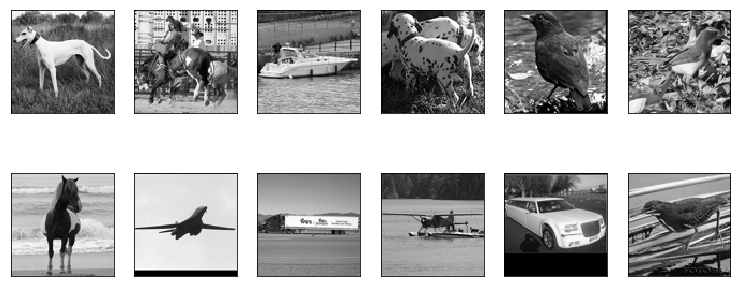

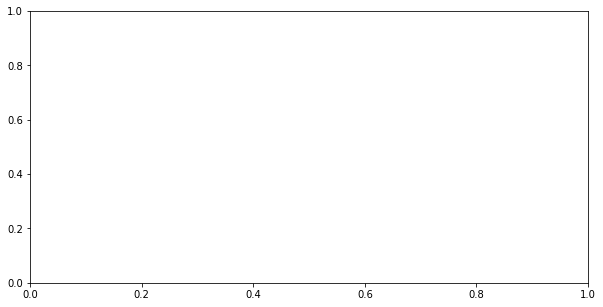

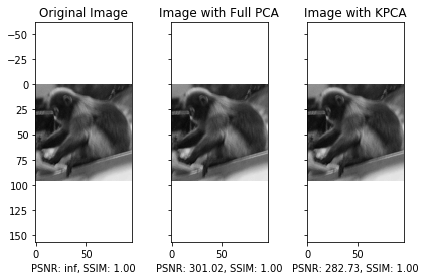

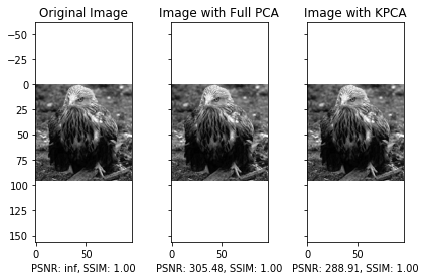

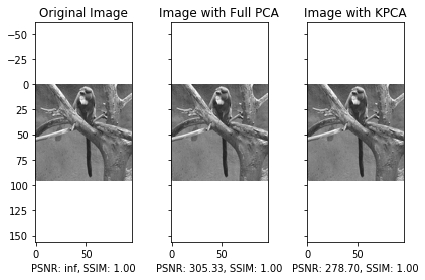

(200 component) Kernal PCA structural similarity percent win ratio: 0.3333333333333333


In [8]:
import warnings
warnings.filterwarnings('ignore')

from skimage import data, img_as_float
from skimage.measure import compare_ssim as ssim
from skimage.measure import compare_psnr as psnr
def mse(x, y):
    return np.linalg.norm(x - y)


def reconstruct_comp(idx_to_reconstruct, plot):

    original = X[idx_to_reconstruct]
    reconstructed_image = pca.inverse_transform(pca.transform(X[idx_to_reconstruct].reshape(1, -1)))
    kpca.fit(X.copy())
    reconstructed_image_kpca = kpca.inverse_transform(kpca.transform(X[idx_to_reconstruct].reshape(1, -1)))

    img = original.reshape((h, w))
    full = reconstructed_image.reshape((h, w))
    kpca_image = reconstructed_image_kpca.reshape((h, w))

    rows, cols = img.shape


    ssim_none = ssim(img, img, data_range=img.max() - img.min())
    psnr_none = psnr(img, img, data_range=img.max() - img.min())

    ssim_full = ssim(img, full, data_range=full.max() - full.min())
    psnr_full = psnr(img, full, data_range=full.max() - full.min())

    ssim_kpca = ssim(img, kpca_image, data_range=kpca_image.max() - kpca_image.min())
    psnr_kpca = psnr(img, kpca_image, data_range=kpca_image.max() - kpca_image.min())



    if plot:
        plt.figure(figsize=(10,5))
        fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(6, 4),
                                 sharex=True, sharey=True)
        ax = axes.ravel()

        label = 'PSNR: {:.2f}, SSIM: {:.2f}'

        ax[0].imshow(img, cmap=plt.cm.gray, vmin=0, vmax=1)
        ax[0].set_xlabel(label.format(psnr_none, ssim_none))
        ax[0].set_title('Original Image')

        ax[1].imshow(full, cmap=plt.cm.gray, vmin=0, vmax=1)
        ax[1].set_xlabel(label.format(psnr_full, ssim_full))
        ax[1].set_title('Image with Full PCA')

        ax[2].imshow(kpca_image, cmap=plt.cm.gray, vmin=0, vmax=1)
        ax[2].set_xlabel(label.format(psnr_kpca, ssim_kpca))
        ax[2].set_title('Image with KPCA')

        plt.tight_layout()
        plt.show()
        
    return (ssim_full, ssim_kpca, )
   


#for showing example
for i in random.sample(range(len(X)), 3):
    score = reconstruct_comp(i, True)

#to compare which is better
kpca_win_count = 0
psnr_win_count = 0
sample_test = 30
close = 0
for i in random.sample(range(len(X)), sample_test):
    score = reconstruct_comp(i, False)
    if score[1]>score[0]:
        kpca_win_count += 1        
    
print("(200 component) Kernal PCA structural similarity percent win ratio:", kpca_win_count/(1.0*sample_test))

The mean squared error is irrelevant due to it not capturing the structure and only the color value.
The structural similarity index takes into account texture to allow comparision of outlining structure. PSNR is the ratio between original peak signal and noise; this would even better identify image quality.

In our comparison method we compared structural similarity and if it was better than the linear pca then it was a win. Since the ratio is 1 is won 100% of the for the sample size of 30. KPCA with polynomial kernal is almost always better than linear. Its PSNR is high indicating visual sharpness and SSIM is high to almost perfect at high component levels.

##### 3.3.1 Comparison at Lower Level of Components

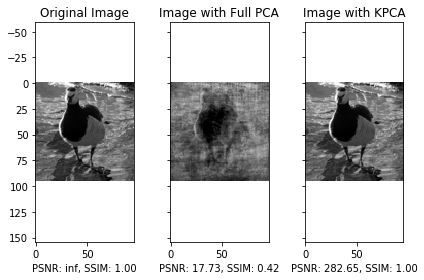

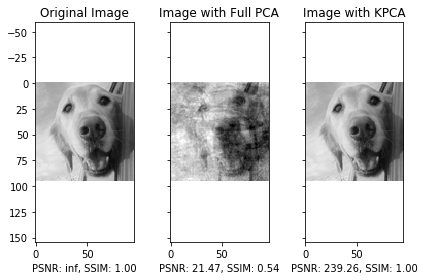

20 component Kernal PCA (POLY) structural similarity percent win ratio: 1.0


In [9]:

n_components = 20
pca = PCA(n_components=n_components)
pca.fit(X.copy())

kpca = KernelPCA(n_components=n_components, kernel='poly',
                fit_inverse_transform=True, gamma=12,
                remove_zero_eig=True)
kpca.fit(X.copy())


for i in random.sample(range(len(X)), 2):
    score = reconstruct_comp(i, True)
    
#to compare which is better
kpca_win_count = 0
sample_test = 30
close = 0
for i in random.sample(range(len(X)), sample_test):
    score = reconstruct_comp(i, False)
    if score[1]>score[0]:
        kpca_win_count += 1        
    
print("20 component Kernal PCA (POLY) structural similarity percent win ratio:", kpca_win_count/(1.0*sample_test))



At low levels of components used, KPCA with a polynomial kernal doesn't compromise on structural similarity; it is almost just as perfect. There seemed to be a decent loss in PSNR, however this is not visible to the naked eye.

##### 3.3.2 Comparion of RBF to POLY kernals

20 comp RBF KPCA


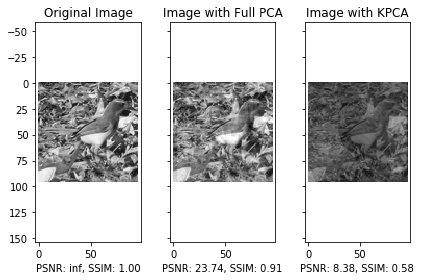

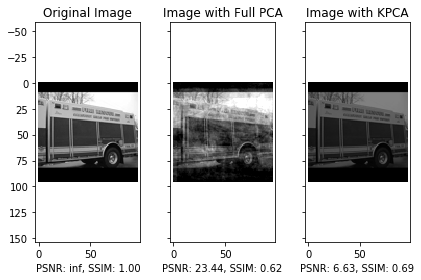

20 comp RBF KPCA


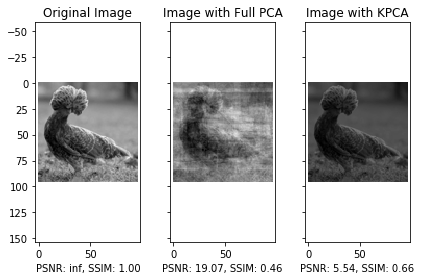

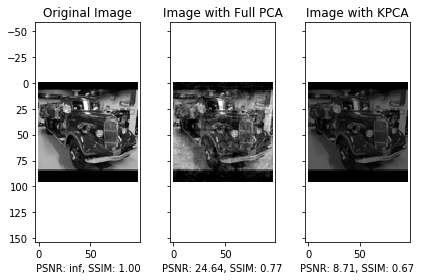

In [10]:
kpca = KernelPCA(n_components=n_components, kernel='rbf',
                fit_inverse_transform=True, gamma=12,
                remove_zero_eig=True)
kpca.fit(X.copy())

print("20 comp RBF KPCA")
for i in random.sample(range(len(X)), 2):
    score = reconstruct_comp(i, True)

    

kpca = KernelPCA(n_components=200, kernel='rbf',
                fit_inverse_transform=True, gamma=12,
                remove_zero_eig=True)
kpca.fit(X.copy())

print("20 comp RBF KPCA")
for i in random.sample(range(len(X)), 2):
    score = reconstruct_comp(i, True)

This example using an RBF kernal shows that not every nonlinear dimensionality reduction is optimal. The difference is that we know that the true function of an object outline can be approximated polynomial function and as a result a polynomial kernal will get better results with a lot less data. The RBF kernal will only out-perform polynomial on the highest level components because the complextiy of the model is infinite whereas the polynomial model is fixed asymptoticall as seen in the last section.

At 50 KPCA RBF was worse than even the linear PCA. In the second test with 200 components PSNR and SSIM were decent but still lower that the of the polynomial kernal. 

Our conclusion is that kernal PCA with a polynomial kernal is best for capturing components of animal images.

#### 3.4

    `[10 points] Perform feature extraction upon the images using any feature extraction technique (e.g., gabor filters, ordered gradients, DAISY, etc.).`

In [46]:
from skimage.feature import daisy
from skimage.io import imshow
from skimage.filters import sobel_h, sobel_v
#img = data.camera()
idx_to_reconstruct = int(np.random.rand(1)*len(X))
img  = X[idx_to_reconstruct].reshape((h,w))


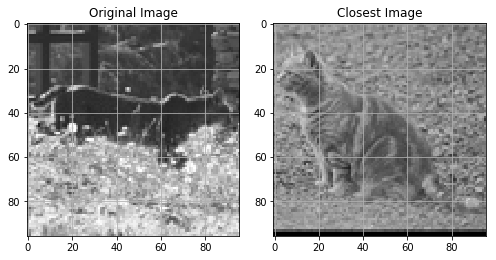

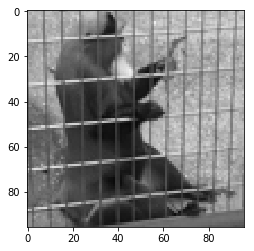

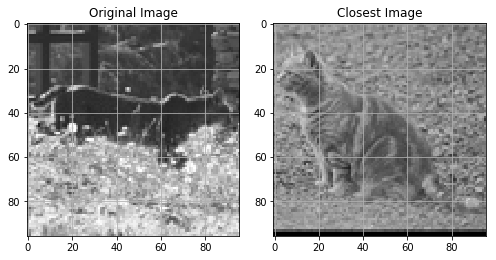

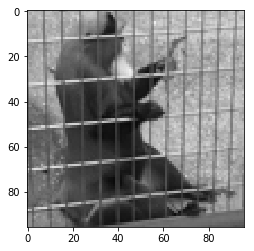

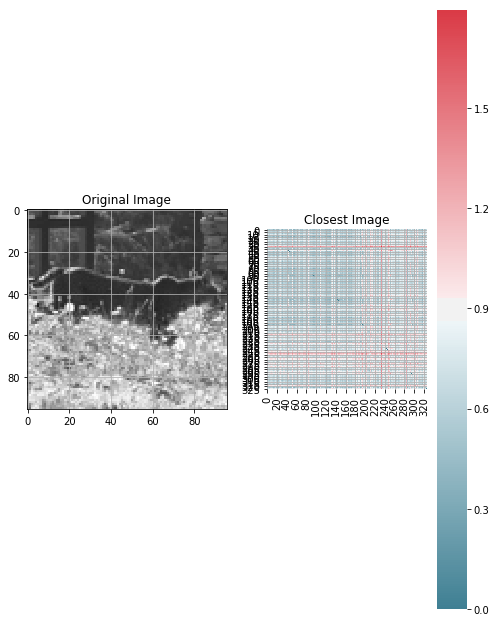

In [47]:
features, img_desc = daisy(img,step=40, radius=10, rings=3, histograms=5, orientations=8, visualize=True)
imshow(img_desc)
plt.grid()
plt.show()

In [67]:
# create a function to tak in the row of the matric and return a new feature
def apply_daisy(row,shape):
    feat = daisy(row.reshape(shape),step=10, radius=10, rings=2, histograms=6, orientations=8, visualize=False)
    return feat.reshape((-1))

%time test_feature = apply_daisy(X[3],(h,w))
test_feature.shape
##daisy for 1 image

CPU times: user 15.4 ms, sys: 2.57 ms, total: 18 ms
Wall time: 15.6 ms


(6656,)

<h4>Read in the Animals Images</h4>

In [68]:
images = []
for filename in glob.glob('./test_animals/*.png'):
    img = mpimg.imread(f'{filename}')
    images.append(rgb2gray(img))
print("number of images:", len(images))
animal_index = len(images) - 1

number of images: 200


In [69]:
##each row is in its own right now so we must flatten
h, w = images[0].shape
print("dim:",h,w)
#each pixel now has a value
print("pixels:", len(images[0].flatten()))

images_features = []
for image in images:
    images_features.append(image.flatten())
X = images_features

dim: 96 96
pixels: 9216


<h4>Read in the Non-Animals Images</h4>

In [70]:
images = []
for filename in glob.glob('./test_non_animals/*.png'):
    img = mpimg.imread(f'{filename}')
    images.append(rgb2gray(img))
print("number of images:", len(images))
animal_index = len(images) - 1

number of images: 126


In [71]:
##each row is in its own right now so we must flatten
h, w = images[0].shape
print("dim:",h,w)
#each pixel now has a value
print("pixels:", len(images[0].flatten()))

images_features = []
for image in images:
    images_features.append(image.flatten())
X += images_features

dim: 96 96
pixels: 9216


In [72]:
%time 

daisy_features = [] 

for i in range(len(X)):
    daisy_features.append(apply_daisy(X[i],(h,w)))
print(np.array(daisy_features).shape)

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 6.91 µs
(326, 6656)


In [73]:
from sklearn.metrics.pairwise import pairwise_distances
# find the pairwise distance between all the different image features
%time dist_matrix = pairwise_distances(daisy_features)


CPU times: user 105 ms, sys: 16.2 ms, total: 122 ms
Wall time: 68.8 ms


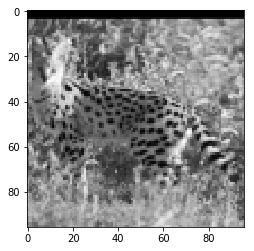

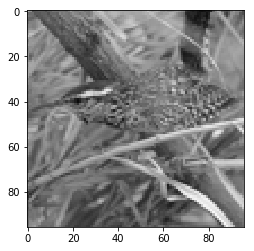

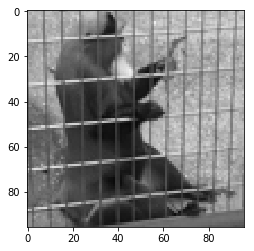

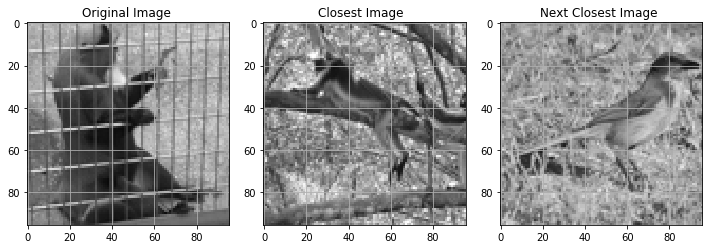

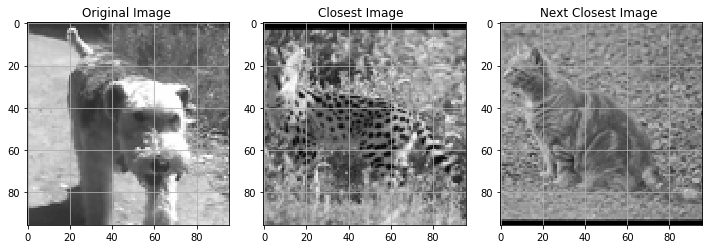

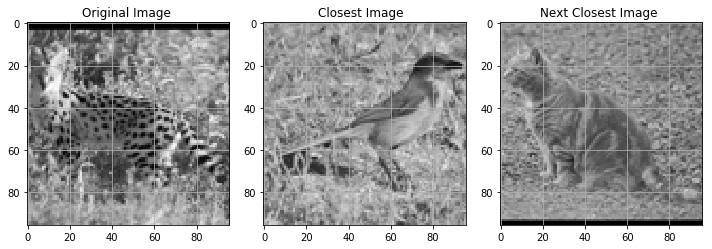

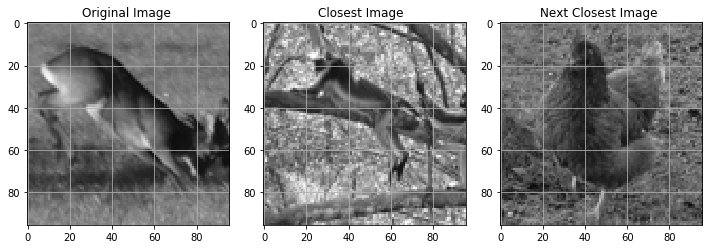

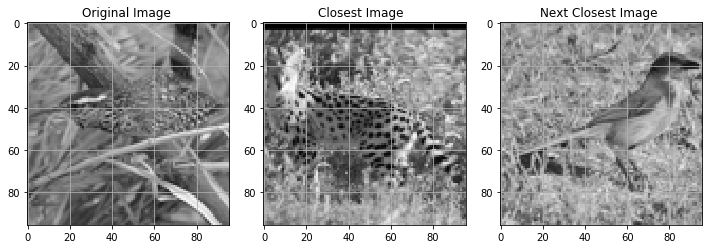

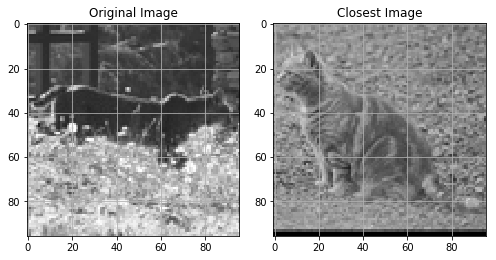

In [74]:
import copy
# find closest image to current image
idx1 = 1
distances = copy.deepcopy(dist_matrix[idx1,:])
distances[idx1] = np.infty # dont pick the same image!
idx2 = np.argmin(distances)

plt.figure(figsize=(7,10))
plt.subplot(1,2,1)
imshow(X[idx1].reshape((h,w)))
plt.title("Original Image")
plt.grid()

plt.subplot(1,2,2)
imshow(X[idx2].reshape((h,w)))
plt.title("Closest Image")
plt.grid()
plt.show()

Is there still something worng?
Is there anything we can conclude?


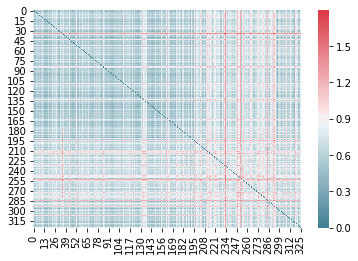

In [75]:
from sklearn.preprocessing import StandardScaler
import seaborn as sns
std = StandardScaler()


import seaborn as sns
cmap = sns.diverging_palette(220, 10, as_cmap=True) # one of the many color mappings
xdata = dist_matrix
sns.heatmap(xdata, cmap=cmap, annot=False)
print('Is there still something worng?')


print('Is there anything we can conclude?')
plt.show()

In [82]:
from ipywidgets import fixed
from ipywidgets import widgets
# put it together inside a nice widget
def closest_image(dmat,idx1):
    distances = copy.deepcopy(dmat[idx1,:]) # get all image diatances
    distances[idx1] = np.infty # dont pick the same image!
    idx2 = np.argmin(distances)
    
    distances[idx2] = np.infty
    idx3 = np.argmin(distances)
    
    plt.figure(figsize=(10,16))
    plt.subplot(1,3,1)
    imshow(X[idx1].reshape((h,w)))
    plt.title("Original Image ")
    plt.grid()

    plt.subplot(1,3,2)
    imshow(X[idx2].reshape((h,w)))
    plt.title("Closest Image  ")
    plt.grid()
    
    plt.subplot(1,3,3)
    imshow(X[idx3].reshape((h,w)))
    plt.title("Next Closest Image ")
    plt.grid()
    plt.show()
n_samples = 325
widgets.interact(closest_image,idx1=(0,n_samples-1,1),dmat=fixed(dist_matrix),__manual=True)

A Jupyter Widget

<function __main__.closest_image>

#### 3.5

        [20 points] Does this feature extraction method show promise for your prediction task? Why? Use visualizations to analyze this questions. For example, visualize the differences between statistics of extracted features in each target class. Another option, use a heat map of the pairwise differences (ordered by class) among all extracted features. Another option, build a nearest neighbor classifier to see actual classification performance.  
        
        Our feature extraction method does show promise for our prediction task because we are able to detect common features of animals and indicate the presence of a live animal within an image. We had an estimated accuracy of *86%* for animals within the pictures.
             

In [ ]:
        #Display 6 (or so) images of indicated presence/non-presence of animals#


### Exceptional Work

`perform feature extraction upon the images using a feature extractor that requires key point matching (such as SIFT/SURF/ORB or others). Then build a nearest neighbor classifier using a method appropriate for your chosen features. You will need to investigate appropriate methods for comparisons with your chosen feature extraction technique. NOTE: this often requires some type of brute force matching per pair of images, which can be computationally expensive).`